# Detection/Classification of Breast Cancer using thermograpy using Resnet18

## Nvidia Jetson nano developer kit

For this Artificial Intelligence project for breast cancer detection on thermal images I used the Nvidia Jetson Nano developer kit. 
The Nvidia Jetson Nano Developer Kit is a powerful and compact platform specifically designed for embedded artificial intelligence (AI) applications. Featuring a Quad-core ARM Cortex-A57 processor, an NVIDIA Maxwell GPU with 128 CUDA cores, and 4 GB of LPDDR4 memory, the Jetson Nano provides significant computing power for deep learning tasks and image processing. It is particularly well-suited for projects requiring embedded intelligence, such as object recognition, image classification, and other AI-related applications. The user-friendly nature and flexibility of the Jetson Nano make it a popular choice among developers looking to integrate AI capabilities into embedded devices and standalone projects.

## Dataset
In the present investigation, a publicly accessible dataset comprising thermographic images related to breast cancer was employed for diagnostic purposes. This dataset encompasses a total of 3,997images, featuring 3,024 images representing healthy cases and 973 images depicting breast diseases. These images are stored in JPEG format with dimensions of 640x480 pixels. Within the dataset, there are 179 images depicting healthy breast conditions and 101 images corresponding to patients with breast conditions. This dataset was sourced from http://visual.ic.uff.br/dmi/. Sample images from the dataset are provided in below.

## Thermography
At specific temperatures, objects naturally emit thermal signals. The nature of these signals, as well as the temperature range, depends on the characteristics of the object. Under usual conditions, the human body, like other objects, emits Infrared (IR) signals. Due to the heat generated by different bodily functions, the emitted IR signals vary from one region to another. This principle finds frequent application in medical examinations, especially in the context of breast cancer screenings.
Breast cancer development is associated with inflammation and increased blood vessel formation, both of which generate higher temperature profiles. Thermography, often referred to as thermal imaging, offers a non-invasive method for capturing thermal maps of specific body areas in the field of medicine. This approach is contactless, non-destructive, and does not involve radiation, making it suitable for repeated use. In the context of breast cancer screening, a thermographic camera is employed to obtain thermal maps of the breasts and their surroundings, highlighting any anomalies.
The resurgence of thermography in medical applications has brought it into focus as an adjunct to image processing techniques, particularly for the diagnosis of breast cancer. Breast thermography capitalizes on the temperature differences beneath the skin between healthy and cancerous breasts. The presence of a breast tumor raises the temperature of the surrounding tissues. Typically, specialists conduct an asymmetric comparison of healthy and affected breasts.
The process of using thermography for breast cancer screening is relatively straightforward. It commences with a physical examination of the breast's surface, allowing the physician to correlate any abnormalities with the thermal map. Subsequently, the individual is required to spend 15 minutes at room temperature to acclimatize. This is carried out in a controlled environment where both humidity and temperature are regulated. During this period, the individual needs to expose the upper body from the waist to the chin. Once the body temperature reaches equilibrium, the individual is asked to place their hands on their sides for the relevant surfaces to be observed. The imaging procedure is then initiated to complete the process.

## Image processing : Histogram Equalization
Histogram equalization is an image processing technique designed to improve the distribution of grayscale levels in an image. By adjusting the distribution of brightness intensities, this method enhances the overall contrast of the image, thereby improving visibility of details and structures. It is particularly useful in correcting brightness and contrast disparities, enabling a better visual interpretation of images, and finds applications in various fields such as computer vision, object recognition, and medical imaging.

**See in 'Image Processing.ipynb' file of this project.**

## Split Images 70% for training and 30% for test
In the field of image classification, creating a balanced and representative dataset is crucial for effectively training and evaluating models. Ideally, the total set of images is divided into two main parts: a training set, typically representing 70% of the total, and a test/validation set, representing the remaining 30%. The training set is used to train the model, allowing it to learn essential features and patterns in the images. Subsequently, the test/validation set, which has not been seen by the model during training, is used to assess the model's actual performance. This separation ensures that the model can generalize effectively to new data, thereby enhancing its reliability and ability to make accurate classifications in real-world scenarios.

**See in 'Split Images.ipynb' file of this project.**


## Classification of Breast Cancer using thermograpy using pre-trained models
In the realm of image classification, the adoption of pre-trained models represents an innovative strategy leveraging neural networks already trained on extensive datasets. This approach capitalizes on the capability of pre-trained models, such as ResNet18, to extract and comprehend intricate features from a variety of images. ResNet18, in particular, is built upon a residual architecture, introducing direct connections between layers to facilitate the learning of hierarchical representations. The use of pre-trained models allows harnessing prior knowledge gained from similar tasks, providing a more robust initialization for new classification tasks. 
In this story, we delve into the various stages of integrating ResNet18, previously trained on extensive datasets, thereby enhancing its ability to capture intricate information. While we also employ other pre-trained models for image classification, we will confine ourselves to presenting and interpreting the results for these models. Indeed, the method and steps will remain identical to those outlined in the detailed presentation of ResNet18. This approach unveils significant potential across diverse applications, ranging from object recognition to the detection of medical pathologies, underscoring the substantial impact of pre-trained models in the field of computer vision.
Installation and prerequisites
On this project it is necessary to install and import the following Python libraries:
- os (already present when you install Python)
- random (already present when you install Python)
- time(already present when you install Python)
- copy (already present when you install Python)
- numpy
- pandas
- cv2 (opencv)
- matplotlib
- seaborn
- sklearn
- torch (Pytorch)
- torchvision

## Import & setup configuration
Below is the list of Python libraries necessary for the implementation and evaluation of our breast cancer detection model based on the Resnet18 pre-trained model.

In [1]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check version of Pytorch
print(torch. __version__)

1.10.0


To see what resources would be used GPU or CPU.

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Path of the train and test folders where both have 2 sub-folder "Sick" and "Healthy"

In [4]:
train_dir = "../../../DataSet/Transformed - DMR - Database For Mastology Research - Visual Lab/train"
test_dir = "../../../DataSet/Transformed - DMR - Database For Mastology Research - Visual Lab/test"

## Resnet18
By using models.resnet18(pretrained=True), we can call a pre-trained model of ResNet18 from The Pytorch API.

In [5]:
model_resnet18 = models.resnet18(pretrained=True)
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Customize model
The customization consists of freezing the base model and changing the output layer to meet our requirements.
**Check the output feature and add a newly fully-connected layer from the pre-trained model**

In [6]:
num_features = model_resnet18.fc.in_features 
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 512


As we can see, there are 512 output features from the original model; therefore, we need to change this by adding a fully connected layer for our classification problem with only 2 target classes.

In [7]:
# Add a fully-connected layer for classification
model_resnet18.fc = nn.Linear(num_features, 2)
model_resnet18 = model_resnet18.to(device)

Using Cross Entropy Loss in the context of classification is justified by its effective ability to measure the divergence between model predictions and true class labels. This loss function facilitates precise learning of relationships between data features and their respective classes. When coupled with the Stochastic Gradient Descent (SGD) optimizer, this combination provides a robust framework for the iterative adjustment of model weights. The SGD, by progressively adjusting weights to minimize Cross Entropy Loss at each iteration, guides the model towards optimal parameters, contributing to an iterative improvement in classification performance.

In [8]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18.parameters(), lr=0.0001, momentum=0.9)

In [9]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Because Resnet accepts input image sizes of (224 * 224), the image must be resized to be (224 * 224), preprocessing for our data, which entails random horizontal flip, rotation, normalization, etc., needs to be defined at first.

In [10]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
# Apply for training and test data
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

## Train model

In the realm of deep learning and image classification, the choice of the number of epochs, or complete iterations through the training dataset, is a pivotal decision. The frequent selection of approximately 30 epochs in our programs arises from a delicate balance between model convergence and temporal efficiency. This value represents a judicious compromise, allowing the model to adapt to the complex features of the training data while avoiding excessive overfitting.

In [12]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model_resnet18.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model_resnet18.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_resnet18(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0463 Acc: 74.8130% Time: 1128.7280s
[Test #1] Loss: 0.0436 Acc: 75.2101% Time: 1260.4748s
Epoch 1 running
[Train #2] Loss: 0.0420 Acc: 76.4874% Time: 2042.1018s
[Test #2] Loss: 0.0395 Acc: 76.8908% Time: 2159.3111s
Epoch 2 running
[Train #3] Loss: 0.0392 Acc: 77.9124% Time: 2944.1674s
[Test #3] Loss: 0.0362 Acc: 78.1513% Time: 3062.6527s
Epoch 3 running
[Train #4] Loss: 0.0373 Acc: 79.5867% Time: 3847.8924s
[Test #4] Loss: 0.0324 Acc: 85.6303% Time: 3966.0144s
Epoch 4 running
[Train #5] Loss: 0.0338 Acc: 81.5105% Time: 4756.8147s
[Test #5] Loss: 0.0284 Acc: 85.1261% Time: 4875.7575s
Epoch 5 running
[Train #6] Loss: 0.0315 Acc: 83.2561% Time: 5669.3215s
[Test #6] Loss: 0.0276 Acc: 84.1176% Time: 5788.9542s
Epoch 6 running
[Train #7] Loss: 0.0295 Acc: 85.1443% Time: 6583.6435s
[Test #7] Loss: 0.0251 Acc: 86.0504% Time: 6703.5977s
Epoch 7 running
[Train #8] Loss: 0.0280 Acc: 85.7855% Time: 7499.8074s
[Test #8] Loss: 0.0207 Acc: 90.3361% Time: 7620.0305s


In [13]:
save_path = 'models/breast_thermo_cancer-classifier_resnet_18_final.pth'
torch.save(model_resnet18.state_dict(), save_path)

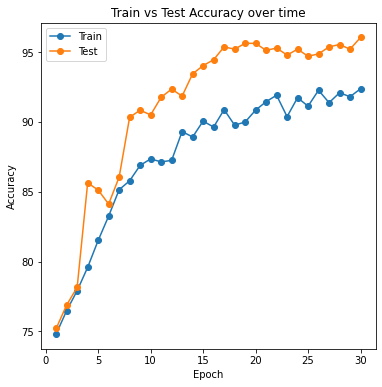

In [14]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

In [15]:
# Get data to check on the performance of each label
y_pred = []
y_true = []


num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model_resnet18.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_resnet18(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

Accuracy on Training set:  0.9605042016806723
Confusion matrix: 
 [[26160   720]
 [  690  8130]]
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     26880
           1       0.92      0.92      0.92      8820

    accuracy                           0.96     35700
   macro avg       0.95      0.95      0.95     35700
weighted avg       0.96      0.96      0.96     35700



<AxesSubplot:title={'center':'Confusion matrix for Breast Cancer classification '}>

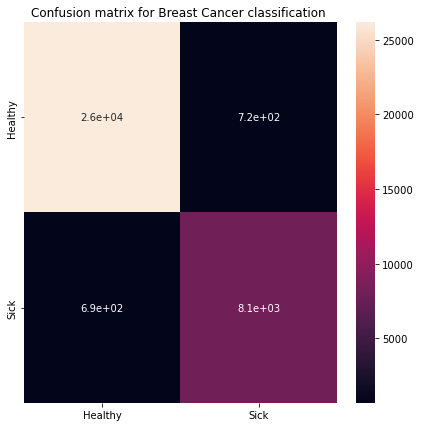

In [16]:
# Visualization and result
# constant for classes
classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for Breast Cancer classification ")
sn.heatmap(df_cm, annot=True)

# Load your saved model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
#import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_resnet18 = models.resnet18(pretrained=True)
num_features = model_resnet18.fc.in_features 
# Add a fully-connected layer for classification
model_resnet18.fc = nn.Linear(num_features, 2)
model_resnet18 = model_resnet18.to(device)
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18.parameters(), lr=0.0001, momentum=0.9)
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_resnet18.load_state_dict(torch.load('models/breast_thermo_cancer-classifier_resnet_18_final.pth'))